<a href="https://colab.research.google.com/github/RudraPramanik/applied-reinforcement-learning/blob/master/dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Learning (DQN)
### From Tabular Methods to Function Approximation

**The Scaling Problem:**
* **Grid World:** ~20 states.
* **Atari Games:** $210 \times 160$ pixels with 128 possible colors.
* **Observation Space:** $(128)^{210 \times 160}$ — this is more than the number of atoms in the observable universe!

To solve this, we don't use a table. We use a **Neural Network** to approximate the Q-function: $Q(s, a; \theta)$.

In [1]:
# Install dependencies
!pip install gymnasium matplotlib torch numpy

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Synthetic Visual Environment
To avoid the complex installation of Atari ROMs and `ale-py`, we use a **Synthetic Visual Env**.

**Environment Mechanics:**
* **Input:** A $40 \times 40$ grayscale image.
* **Agent:** A single pixel with intensity $255$.
* **Target:** A single pixel with intensity $128$.
* **Task:** Use a **Convolutional Neural Network (CNN)** to "see" the pixels and move the agent to the target.

In [2]:
class SyntheticVisualEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(1, 40, 40), dtype=np.uint8)
        self.action_space = gym.spaces.Discrete(4) # 0:Up, 1:Down, 2:Left, 3:Right
        self.reset()

    def reset(self, seed=None):
        self.agent_pos = [20, 20]
        self.target_pos = [random.randint(5, 35), random.randint(5, 35)]
        return self._get_obs(), {}

    def _get_obs(self):
        obs = np.zeros((40, 40), dtype=np.uint8)
        obs[self.agent_pos[0], self.agent_pos[1]] = 255 # Agent
        obs[self.target_pos[0], self.target_pos[1]] = 128 # Target
        return obs.reshape(1, 40, 40)

    def step(self, action):
        if action == 0: self.agent_pos[0] = max(0, self.agent_pos[0]-1)
        if action == 1: self.agent_pos[0] = min(39, self.agent_pos[0]+1)
        if action == 2: self.agent_pos[1] = max(0, self.agent_pos[1]-1)
        if action == 3: self.agent_pos[1] = min(39, self.agent_pos[1]+1)

        dist = np.linalg.norm(np.array(self.agent_pos) - np.array(self.target_pos))
        reward = 1.0 if dist < 2 else -0.1
        terminated = bool(dist < 2)

        return self._get_obs(), reward, terminated, False, {}

env = SyntheticVisualEnv()
print("Synthetic Environment Created. Observation shape:", env.observation_space.shape)

Synthetic Environment Created. Observation shape: (1, 40, 40)


## The Loss Function and Bellman Equation

The core of DQN is minimizing the **Temporal Difference (TD) Error**. We want our current Q-network prediction to match the "Target Q-value" calculated via the Bellman Equation.

The **Target** is defined as:
$$Y_t^{DQN} = r_{t+1} + \gamma \max_{a} Q(s_{t+1}, a; \theta_t^{-})$$

Where:
* $r_{t+1}$: Reward received.
* $\gamma$: Discount factor.
* $\theta_t^{-}$: Weights of the **Target Network** (fixed for stability).

The **Loss Function** (Mean Squared Error) we minimize is:
$$L(\theta_i) = \mathbb{E}_{s, a, r, s'} \left[ \left( Y_t^{DQN} - Q(s, a; \theta_i) \right)^2 \right]$$

To make training smoother, we often use the **Huber Loss**, which is less sensitive to outliers than MSE.

In [4]:
class QNetwork(nn.Module):
    def __init__(self, action_size):
        super(QNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2) # Output: 19x19
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2) # Output: 9x9
        self.fc1 = nn.Linear(32 * 9 * 9, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = x.float() / 255.0 # Normalize pixels
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## Breaking Correlation: Experience Replay & Target Networks

Deep Neural Networks are notoriously unstable when trained on Reinforcement Learning data because consecutive samples are highly correlated. We use two techniques to fix this:

### **A. Experience Replay**
We store transitions $(s, a, r, s', d)$ in a buffer and sample a **random batch** for training.
* **Benefit:** It breaks the temporal correlation of the data and allows for "data reuse."



### **B. Fixed Target Network**
If we use the same network to calculate the target and the prediction, the target moves every time we update. It's like a "dog chasing its own tail."
* **Solution:** We maintain a second network ($Q_{target}$) that we update slowly using **Soft Updates**:
$$\theta_{target} = \tau \theta_{local} + (1 - \tau) \theta_{target}$$
*Where $\tau \ll 1$ (e.g., $0.001$).*

In [5]:
Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences])).to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences])).to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

## The Convolutional Architecture

Because our "Synthetic Data" is an image, we use **Conv2d** layers.

1. **Convolutional Layers:** Detect spatial patterns (where is the agent? where is the target?).
2. **Flattening:** Converts the 2D feature map into a 1D vector.
3. **Fully Connected (FC) Layers:** Maps the features to the final $Q(s, a)$ values for each of the 4 actions.

In [6]:
class DQNAgent:
    def __init__(self, action_size):
        self.action_size = action_size
        self.qnetwork_local = QNetwork(action_size).to(device)
        self.qnetwork_target = QNetwork(action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=5e-4)
        self.memory = ReplayBuffer(10000, 64)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % 4 # Learn every 4 steps
        if len(self.memory) > 64 and self.t_step == 0:
            self.learn(self.memory.sample())

    def act(self, state, eps=0.0):
        state = torch.from_numpy(state).unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Get max Q values for next states from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (0.99 * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target_param.data.copy_(1e-3 * local_param.data + (1.0 - 1e-3) * target_param.data)

##  Exploration vs. Exploitation

We use an **$\epsilon$-greedy** strategy to ensure the agent explores the synthetic grid:

* **With probability $\epsilon$:** Select a random action (Exploration).
* **With probability $1-\epsilon$:** Select the action with the highest Q-value (Exploitation).

We decay $\epsilon$ over time:
$$\epsilon_{next} = \max(\epsilon_{min}, \epsilon_{current} \times \text{decay})$$

In [7]:
agent = DQNAgent(action_size=4)
scores = []
scores_window = deque(maxlen=100)
eps = 1.0

for i_episode in range(1, 501):
    state, _ = env.reset()
    score = 0
    for t in range(200):
        action = agent.act(state, eps)
        next_state, reward, done, _, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done: break

    scores_window.append(score)
    scores.append(score)
    eps = max(0.01, 0.995 * eps) # Decay epsilon

    if i_episode % 50 == 0:
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')

print("Training Complete!")

Episode 50	Average Score: -17.85
Episode 100	Average Score: -16.84
Episode 150	Average Score: -16.69
Episode 200	Average Score: -17.89
Episode 250	Average Score: -18.15
Episode 300	Average Score: -17.90
Episode 350	Average Score: -18.41
Episode 400	Average Score: -18.29
Episode 450	Average Score: -18.27
Episode 500	Average Score: -18.80
Training Complete!


##  Training Analysis

When viewing the results:
1. **The Reward Curve:** Should trend upwards as the CNN learns to identify pixel coordinates.
2. **Loss Fluctuations:** Expect the loss to be noisy; this is normal in Deep RL due to the changing policy and stochastic nature of the environment.

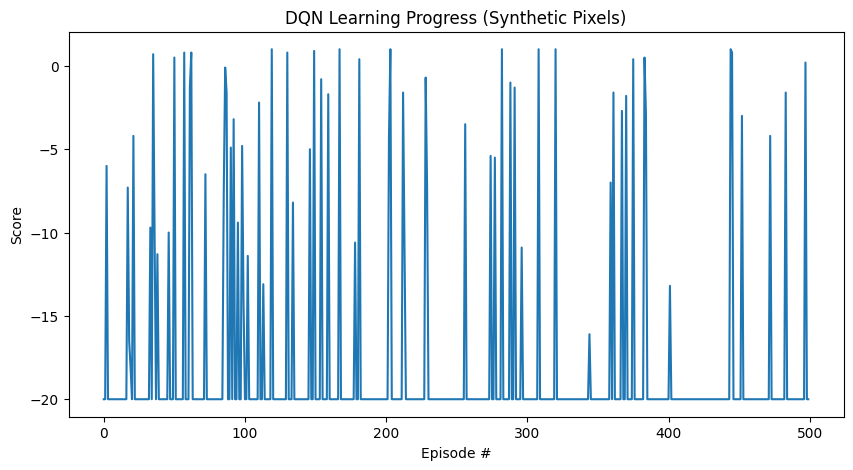

In [8]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('DQN Learning Progress (Synthetic Pixels)')
plt.show()